In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

from utils import *
from learner import *

In [2]:
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)

        # Decoder layers
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# Initialize the VAE model, optimizer, and other parameters
input_size = 784  # MNIST images are 28x28
hidden_size = 400
latent_size = 20
vae = VAE(input_size, hidden_size, latent_size)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

# Set up data loader (assuming MNIST for this example)
from torchvision import datasets, transforms
batch_size = 128
log_interval = 10
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

# Train the VAE
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch)


Train Epoch: 1 [0/60000 (0%)]	Loss: 546.486328
Train Epoch: 1 [1280/60000 (2%)]	Loss: 307.112946
Train Epoch: 1 [2560/60000 (4%)]	Loss: 241.871826
Train Epoch: 1 [3840/60000 (6%)]	Loss: 212.015320
Train Epoch: 1 [5120/60000 (9%)]	Loss: 211.380630
Train Epoch: 1 [6400/60000 (11%)]	Loss: 212.765167
Train Epoch: 1 [7680/60000 (13%)]	Loss: 208.622681
Train Epoch: 1 [8960/60000 (15%)]	Loss: 204.940521
Train Epoch: 1 [10240/60000 (17%)]	Loss: 201.097534
Train Epoch: 1 [11520/60000 (19%)]	Loss: 192.752884
Train Epoch: 1 [12800/60000 (21%)]	Loss: 183.877533
Train Epoch: 1 [14080/60000 (23%)]	Loss: 183.649689
Train Epoch: 1 [15360/60000 (26%)]	Loss: 171.363373
Train Epoch: 1 [16640/60000 (28%)]	Loss: 176.303970
Train Epoch: 1 [17920/60000 (30%)]	Loss: 164.509201
Train Epoch: 1 [19200/60000 (32%)]	Loss: 166.416977
Train Epoch: 1 [20480/60000 (34%)]	Loss: 164.970581
Train Epoch: 1 [21760/60000 (36%)]	Loss: 155.383484
Train Epoch: 1 [23040/60000 (38%)]	Loss: 165.979874
Train Epoch: 1 [24320/60000 

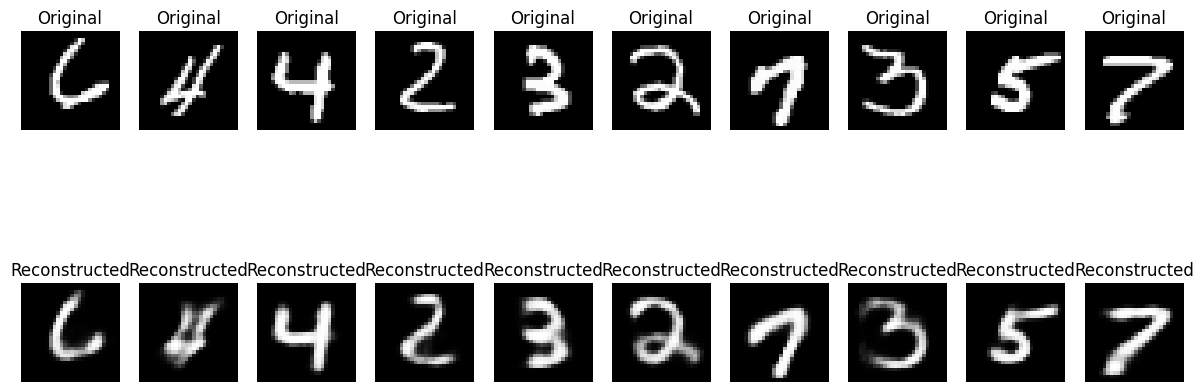

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reconstructions(vae, data, num_samples=10):
    with torch.no_grad():
        recon_batch, _, _ = vae(data)
    
    # Plot original images
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(data[i].view(28, 28).numpy(), cmap='gray')
        plt.title('Original')
        plt.axis('off')

    # Plot reconstructed images
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(recon_batch[i].view(28, 28).numpy(), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

    plt.show()

# Assuming you have a test_loader for your test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

# Get a batch of test data
data, _ = next(iter(test_loader))

# Perform inference and plot reconstructions
plot_reconstructions(vae, data)
